In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

y = train['Survived']

PassengerId = test['PassengerId']

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Checking for NaNs in dataset
full_data = [train, test]
for dataset in full_data:
    print(dataset.isnull().sum())
    print('-'*30)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
------------------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
------------------------------


In [5]:
# Treating missing data in Age (both dataset)
full_data = [train, test]

for dataset in full_data:
    dataset['Age'].fillna(dataset['Age'].mean(), inplace = True)

# Treating missing data in Fare (test set)
test['Fare'].fillna(test['Fare'].mean(), inplace = True)

In [6]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [7]:
# Treating missing data in Embarked (train set)
train['Embarked'].fillna('S', inplace = True)

In [8]:
# Dropping not important features
for dataset in full_data:
    dataset.drop(['Cabin', 'Ticket', 'PassengerId'], axis = 1, inplace=True)

In [9]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [10]:
# Checking for NaNs in dataset again
full_data = [train, test]
for dataset in full_data:
    print(dataset.isnull().sum())
    print('-'*30)

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
------------------------------
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
------------------------------


In [11]:
# Feature Engineering

# Family Size
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# Verifying if passenger is alone 
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [12]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title
0,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,0,S,2,0,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,3,C,2,0,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,1.0,0,0,1,S,1,1,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,3,S,2,0,Mrs
4,0,3,"Allen, Mr. William Henry",male,2.0,0,0,1,S,1,1,Mr


In [13]:
# Dropping a few more columns

for dataset in full_data:
    dataset.drop(['Name', 'SibSp'], axis = 1, inplace=True)

In [14]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,FamilySize,IsAlone,Title
0,0,3,male,1.0,0,0,S,2,0,Mr
1,1,1,female,2.0,0,3,C,2,0,Mrs
2,1,3,female,1.0,0,1,S,1,1,Miss
3,1,1,female,2.0,0,3,S,2,0,Mrs
4,0,3,male,2.0,0,1,S,1,1,Mr


In [15]:
# Categorizing

train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [16]:
test.head()

,Pclass,Age,Parch,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,2.0,0,0,1,1,0,1,0,1,0,0,0,1,0,0
1,3,2.0,0,0,2,0,1,0,0,0,1,0,0,0,1,0
2,2,3.0,0,1,1,1,0,1,0,1,0,0,0,1,0,0
3,3,1.0,0,1,1,1,0,1,0,0,1,0,0,1,0,0
4,3,1.0,1,1,3,0,1,0,0,0,1,0,0,0,1,0


In [17]:
train.drop(['Sex_male', 'Embarked_C', 'Title_Mr'], axis = 1, inplace=True)

In [18]:
test.drop(['Sex_male', 'Embarked_C', 'Title_Mr'], axis = 1, inplace=True)

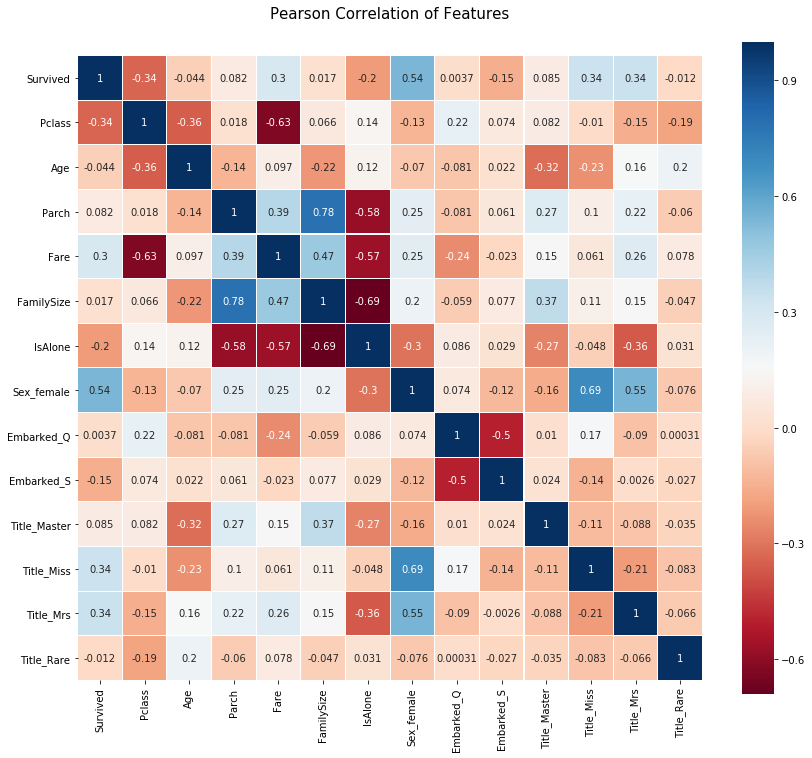

In [19]:
# plotting correlation between features and label
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [20]:
train.drop(['Survived'], axis = 1, inplace=True)

In [21]:
train.shape

(891, 13)

In [22]:
test.shape

(418, 13)

In [23]:
# Random Forest parameters
rf_params = {
    'n_jobs': 2,
    'n_estimators': 500,
     'warm_start': True, 
     'max_features': 'auto',
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': 2,
    'n_estimators':500,
    'max_features': 'auto',
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     'max_features': 'auto',
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'rbf',
    'C' : 0.025,
    'gamma': 0.5
    }

In [24]:
# Creating the classifiers
rf = RandomForestClassifier(**rf_params)
et = ExtraTreesClassifier(**et_params)
ada = AdaBoostClassifier(**ada_params)
gb = GradientBoostingClassifier(**gb_params)
svc = SVC(**svc_params)

#classifiers = [rf, et, ada, gb, svc]
classifiers = {'Random Forest': rf, 
               'Extra Trees': et, 
               'AdaBoost': ada, 
               'Gradient Boosting': gb, 
               'Support Vectors Classifier': svc}

In [25]:
# Training and evaluating the classifiers

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
for model, clf in classifiers.items():
    print('Model: {}'.format(model))
    accuracies = []
    
    tic = time.time()
    for train_index, test_index in sss.split(train, y):
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        
    print('Time elapsed: {}s'.format(time.time() - tic))
    print('Accuracy: {} +/- {}'.format(np.array(accuracies).mean(), np.array(accuracies).std()))
    print()
         

Model: AdaBoost
Time elapsed: 3.1446120738983154s
Accuracy: 0.8134078212290504 +/- 0.021375560301350863

Model: Support Vectors Classifier
Time elapsed: 0.1439225673675537s
Accuracy: 0.6145251396648045 +/- 0.0

Model: Extra Trees
Time elapsed: 4.165096759796143s
Accuracy: 0.8167597765363128 +/- 0.025819486052047716

Model: Gradient Boosting
Time elapsed: 3.174638509750366s
Accuracy: 0.7955307262569832 +/- 0.016796979193712765

Model: Random Forest
Time elapsed: 1.7730803489685059s
Accuracy: 0.8301675977653631 +/- 0.02166560830130202



In [26]:
# Creating submission file
y_pred = rf.predict(test)
results = pd.DataFrame({"PassengerId": PassengerId, "Survived": y_pred}).to_csv("submission.csv", index=None)
